# TV shows Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the `popularity` of a movie or TV show

<img src="image.jpg" width=300 />




The dataset contains a list of movies and TV shows with the following characteristics:
- `title`: title of the movie in english
- `original_title`: original title of the movie 
- `duration_min`: duration of the movie in minutes
- `popularity`: popularity of the movie in terms of review scores
- `release_date`: release date
- `description`: short summary of the movie
- `budget`: budget spent to produce the movie in USD
- `revenue`: movie revenue in USD 
- `original_language`: original language 
- `status`: is the movie already released or not
- `number_of_awards_won`: number of awards won for the movie
- `number_of_nominations`: number of nominations
- `has_collection`: if the movie is part of a sequel or not
- `all_genres`: genres that described the movie (can be zero, one or many!) 
- `top_countries`: countries where the movie was produced (can be zero, one or many!) 
- `number_of_top_productions`: number of top production companies that produced the film if any. 
Top production companies includes: Warner Bros, Universal Pictures, Paramount Pictures, Canal+, etc...
- `available_in_english`: whether the movie is available in english or not

## Imports

Run the following cell to load the basic packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nbresult import ChallengeResult
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

## Data collection

📝 **Load the `movie_popularity.csv` dataset from the provided this [URL](https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/tv_movies_popularity.csv)**
- First, check and remove the rows that may be complete duplicate from one another (we never know!)
- Then, drop the columns that have too much missing values
- Finally, drop the few remaining rows that have missing values
- Store the result in a `DataFrame` named `data`

In [2]:
# YOUR CODE HERE
data = pd.read_csv("tv_movies_popularity.csv")
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)
data.head()

,original_title,title,popularity,release_date,duration_min,description,budget,revenue,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,Hot Tub Time Machine 2,Hot Tub Time Machine 2,6.575393,2015-02-20,93.0,"When Lou's shot in the groin, Nick and Jacob d...",14000000,12314651.0,en,Released,0,2,1,Comedy,United States of America,3,True
1,The Princess Diaries 2: Royal Engagement,The Princess Diaries 2: Royal Engagement,8.248895,2004-08-06,113.0,"Now settled in Genovia, Princess Mia faces a n...",40000000,95149435.0,en,Released,1,2,1,"Comedy, Drama, Family, Romance",United States of America,1,True
2,Whiplash,Whiplash,64.299990,2014-10-10,105.0,A promising young drummer enrolls at a cut-thr...,3300000,13092000.0,en,Released,97,145,0,Drama,United States of America,0,True
3,Kahaani,Kahaani,3.174936,2012-03-09,122.0,A pregnant woman's search for her missing husb...,1200000,16000000.0,hi,Released,23,18,0,"Drama, Thriller",India,0,True
4,The Possession,The Possession,7.286477,2012-08-30,92.0,A young girl buys an antique box at a yard sal...,14000000,85446075.0,en,Released,0,6,0,"Horror, Thriller","Canada, United States of America",0,True


In [3]:
len(data.columns)

17

### 🧪 Run the following cell to save your results

In [4]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "data_cleaning",
    columns=data.columns,
    cleaning=sum(data.isnull().sum()),
    shape=data.shape)
result.write()

## Baseline model

### The metric

📝 **We want to predict `popularity`: Start by plotting a histogram of the target to visualize it**

📝 **Which sklearn's scoring [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use if we want it to:**

- Be better when greater (i.e. metric_good_model > metric_bad_model)
- Penalize **more** an error between 10 and 20 compared with an error between 110 and 120
- Said otherwise, what matter should be the **relative error ratio**, more than the absolute error difference

Hint: the histogram plotted above should give you some intuition about it

👉 Store its exact [sklearn scoring name](https://scikit-learn.org/stable/modules/model_evaluation.html) as `string` in the variable `scoring` below.

🚨 You must use this metric for the rest of the challenge

<AxesSubplot:xlabel='popularity', ylabel='Count'>

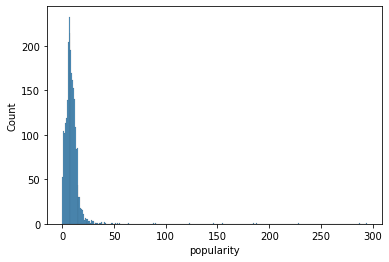

In [5]:
# YOUR CODE HERE
sns.histplot(x="popularity", data=data)

In [6]:
scoring = "neg_mean_absolute_percentage_error"

<details>
    <summary>💡 Hint</summary>
It is around here!
<img src="scores.jpg" width=200 height=400 />
</details>

### X,y

**📝 Define `X` as the features Dataframe (keep all features) and `y` as the target Series.**

In [7]:
# YOUR CODE HERE
X = data.copy().drop(columns="popularity")
y = data["popularity"]

### Basic pipeline

📝 **Check unique values per features**

In [8]:
data.shape

(2617, 17)

In [9]:
# YOUR CODE HERE
X.nunique()

original_title               2594
title                        2591
release_date                 2148
duration_min                  127
description                  2615
budget                        365
revenue                      2508
original_language              31
status                          2
number_of_awards_won           90
number_of_nominations         135
has_collection                  2
all_genres                    491
top_countries                 182
number_of_top_productions       5
available_in_english            2
dtype: int64

In this baseline, let's forget about the columns below that are difficult to process

In [10]:
text = ['description', 'original_title', 'title']
dates = ['release_date'] 

We will simply scale the numerical features and one-hot-encode the categorical ones remaining

📝 **Prepare 2 `list`s of features names as `str`**:
- `numerical` which contains **only** numerical features
- `categorical` which contains **only** categorical features (exept text and dates above)

In [11]:
X.columns

Index(['original_title', 'title', 'release_date', 'duration_min',
       'description', 'budget', 'revenue', 'original_language', 'status',
       'number_of_awards_won', 'number_of_nominations', 'has_collection',
       'all_genres', 'top_countries', 'number_of_top_productions',
       'available_in_english'],
      dtype='object')

In [12]:
# YOUR CODE HERE
numerical = ['duration_min','budget','number_of_top_productions']
categorical = ['original_language','status','all_genres', 'top_countries','available_in_english']

### Pipelining

You are going to build a basic pipeline made of a basic preprocessing and a trees-based model of your choice.

#### Preprocessing pipeline

**📝 Create a basic preprocessing pipeline for the 2 types of features above:**
- It should scale the `numerical` features
- one-hot-encode the `categorical` and `boolean` features
- drop the others
- Store your pipeline in a `basic_preprocessing` variable

In [13]:
# Execute this cell to enable a nice display for your pipelines
from sklearn import set_config; set_config(display='diagram')

In [14]:
# YOUR CODE HERE
basic_preprocessing = make_column_transformer(
        (StandardScaler(), numerical),
        (OneHotEncoder(handle_unknown="ignore"), categorical),
        remainder="drop")

**📝 Encode the features and store the result in the variable `X_basic_preprocessing`.**

In [15]:
# YOUR CODE HERE
X_basic_preprocessing = basic_preprocessing.fit_transform(X)
X_basic_preprocessing.shape

(2617, 711)

**❓ How many features has been generated by the preprocessing? What do you think about this number?**

> 712 it is very high

#### Modeling pipeline

Let's add a model to our pipe. With so many features one-hot-encoded, we **need a model which can act as a feature selector**

👉 A linear model regularized with L1 penalty is a good starting point.


**📝 Create a `basic_pipeline` which encapsulate the `basic_preprocessing` pipeline + a linear model with a L1 penalty**

- store the resulting pipeline as `basic_pipeline`
- don't fine-tune it


<details>
    <summary>Hints</summary>

Choose your model from the list [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)

</details>

In [16]:
# YOUR CODE HERE
basic_pipeline = make_pipeline(basic_preprocessing, Lasso())

### Cross-validated baseline

**📝 Perform a cross-validated evaluation of your baseline model using the metric you defined above. Store the results of this evaluation as an `array` of floating scores in the `basic_scores` variable.**

In [17]:
# YOUR CODE HERE
basic_scores = cross_val_score(basic_pipeline, X, y, cv=5, scoring=scoring)

In [18]:
basic_scores.mean()

-0.9417695343563119

### 🧪 Save your results

Run the following cell to save your results

In [19]:
ChallengeResult(
    'baseline',
    metric=scoring,
    features=[categorical,numerical],
    preproc=basic_preprocessing,
    preproc_shape=X_basic_preprocessing.shape,
    pipe=basic_pipeline,
    scores=basic_scores
).write()

## Feature engineering

### Time Features


👉 Let's try to improve performance using the feature `release_date`, and especially its `month` and `year`.

ℹ️ If you want to skip this section, you can move directly to the next one: _Advanced categorical features_.

**📝 Complete the custom transformer `TimeFeaturesExtractor` below**

Running
```python
TimeFeaturesExtractor().fit_transform(X[['release_date']])
``` 
should return something like

|    |   month |   year |
|---:|--------:|-------:|
|  0 |       2 |   2015 |
|  1 |       8 |   2004 |
|  2 |      10 |   2014 |
|  3 |       3 |   2012 |
|  4 |       8 |   2012 |


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeFeaturesExtractor(BaseEstimator, TransformerMixin):
    """Extract the 2 time features from a date"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Params:
        X: DataFrame
        y: Series
        
        Returns a DataFrame with 2 columns containing the time features as integers extracted from the release_date.
        """
        name_column = X.columns[0]
        X_transform = X.copy()
        X_transform["month"] = X[name_column].str[5:7].str.lstrip("0").astype(int)
        X_transform["year"] = X[name_column].str[:4].astype(int)
        X_transform.drop(columns=name_column,inplace=True)
        return X_transform
        
        

In [21]:
# Try your transformer and save your new features here
X_time_features = TimeFeaturesExtractor().fit_transform(X[['release_date']])
X_time_features.head()

,month,year
0,2,2015
1,8,2004
2,10,2014
3,3,2012
4,8,2012


We still have 2 problems to solve
- `month` is cyclical: 12 should be a close to 1 as to 11, right? 
- `year` is not scaled

**📝 Build a final custom transformer `CyclicalEncoder` so that**

Running
```python
CyclicalEncoder().fit_transform(X_time_features)
``` 
should return something like this

|    |    month_cos |   month_sin |      year |
|---:|-------------:|------------:|----------:|
|  0 |  0.5         |    0.866025 | 0.0466039 |
|  1 | -0.5         |   -0.866025 | 0.0411502 |
|  2 |  0.5         |   -0.866025 | 0.0461081 |
|  3 |  6.12323e-17 |    1        | 0.0451165 |
|  4 | -0.5         |   -0.866025 | 0.0451165 |

With the cyclical encoding is done as below
- `month_cos = 2 * math.pi / 12 * X[['month']] `
- `month_sin = 2 * math.pi / 12 * X[['month']] `

And the `year` begin min-max scaled

In [22]:
from sklearn.base import BaseEstimator, TransformerMixin
import math

class CyclicalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode a cyclical feature
    """
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        Compute here what you need for the transform phase and store it as instance variable
        """
        self.scaler = MinMaxScaler()
        self.scaler.fit(X[["year"]])
        return self

    def transform(self, X, y=None):
        """
        Compute and returns the final DataFrame
        """
        X_transform = X.copy()
        X_transform["month_cos"] = np.cos((2 * math.pi / 12) * X[['month']])
        X_transform["month_sin"] = np.sin((2 * math.pi / 12 )* X[['month']])
        X_transform.drop(columns=X.columns,inplace=True)
        X_transform["year"] = self.scaler.transform(X[["year"]])
        return X_transform

In [23]:
# Try your transformer and save your new features here
X_time_cyclical = CyclicalEncoder().fit_transform(X_time_features)
X_time_cyclical.head()

,month_cos,month_sin,year
0,5.000000e-01,0.866025,0.979167
1,-5.000000e-01,-0.866025,0.864583
2,5.000000e-01,-0.866025,0.968750
3,6.123234e-17,1.000000,0.947917
4,-5.000000e-01,-0.866025,0.947917


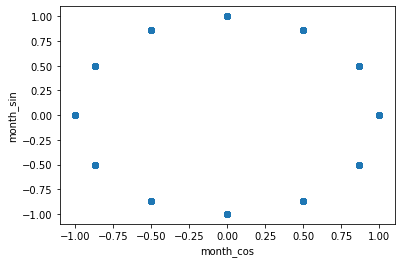

In [24]:
# Check that this form a circle with 12 points
plt.scatter(X_time_cyclical['month_cos'],
            X_time_cyclical['month_sin'])
plt.xlabel("month_cos"); plt.ylabel("month_sin");

**📝 Enhance your `basic_pipeline` with a new preprocessing including both `TimeFeaturesExtractor` and `CyclicalFeatureExtractor`:**

- Just use `TimeFeatureExtractor` if you haven't had time to do the `Cyclical` one
- Store this new pipeline as `time_pipeline`
- Keep same estimator for now

In [25]:
# YOUR CODE HERE
time_preprocessing = make_column_transformer(
        (StandardScaler(), numerical),
        (OneHotEncoder(handle_unknown="ignore"), categorical),
        (make_pipeline(TimeFeaturesExtractor(),CyclicalEncoder()),dates),
        remainder="drop")

time_pipeline = make_pipeline(time_preprocessing, Lasso())

In [26]:
cross_val_score(time_pipeline, X, y, cv=5, scoring=scoring).mean() 

-0.9417695343563119

### Advanced categorical encoder to reduce the number of features

ℹ️ Most of it has already been coded for you and it shouldn't take long. Still if you want to skip it and move to the next section: _Model Tuning_

👉 We need to reduce the number of features to one-hot-encode, which arise from the high cardinality of `all_genres` and `top_countries`

In [27]:
X[['all_genres', 'top_countries']].nunique()

all_genres       491
top_countries    182
dtype: int64

👇 Both share a common pattern: there can be more than 1 country and more than 1 genre per movie.

In [28]:
X[['all_genres', 'top_countries']].tail()

,all_genres,top_countries
2612,"Comedy, Romance",United States of America
2613,"Drama, Music","Denmark, Sweden"
2614,"Action, Crime, Mystery, Thriller",United States of America
2615,"Comedy, Romance",United States of America
2616,"Action, Mystery, Thriller",United States of America


👉 Run the cell below where we have coded for you a custom transformer `CustomGenreAndCountryEncoder` which: 
- Select the 10 most frequent genres and the 5 most frequent countries
- Encode `all_genres` into 10 One Hot Encoded features
- Encode `top_countries` into 5 One Hot Encoded features

In [29]:
from collections import Counter
from sklearn.base import BaseEstimator, TransformerMixin

class CustomGenreAndCountryEncoder(BaseEstimator, TransformerMixin):
    """
    Encoding the all_genres and top_companies features which are multi-categorical :
    a movie has several possible genres and countries of productions!
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        compute top genres and top countries of productions from all_genres and top_countries features
        """

        # compute top 10 genres       
        list_of_genres = list(X['all_genres'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_genres = [m[0] for m in Counter([i for j in list_of_genres for i in j]).most_common(10)]

        # save top_genres in dedicated instance variable
        self.top_genres = top_genres
        
         # compute top 5 countries       
        list_of_countries = list(X['top_countries'].apply(lambda x: [i.strip() for i in x.split(",")] if x != [''] else []).values)
        top_countries = [m[0] for m in Counter([i for j in list_of_countries for i in j]).most_common(5)]

        # save top_countries in dedicated instance variable
        self.top_countries = top_countries

        return self

    def transform(self, X, y=None):
        """
        encoding genre and country
        """
        X_new = X.copy()
        for genre in self.top_genres:
            X_new['genre_' + genre] = X_new['all_genres'].apply(lambda x: 1 if genre in x else 0)
        X_new = X_new.drop(columns=["all_genres"])
        for country in self.top_countries:
            X_new['country_' + country] = X_new['top_countries'].apply(lambda x: 1 if country in x else 0)
        X_new = X_new.drop(columns=["top_countries"])
        return X_new

In [30]:
# Check it out
X_custom = CustomGenreAndCountryEncoder().fit_transform(X[['all_genres', 'top_countries']])
print(X_custom.shape)
X_custom.head()

(2617, 15)


,genre_Drama,genre_Comedy,genre_Thriller,genre_Action,genre_Romance,genre_Crime,genre_Adventure,genre_Horror,genre_Science Fiction,genre_Family,country_United States of America,country_United Kingdom,country_France,country_Germany,country_Canada
0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1


**📝 Compute your `final_pipeline` by integrating all these transformers** (or all those you have coded)

- `CustomGenreAndCountryEncoder`
- `TimeFeaturesExtractor`
- `CyclicalFeatureExtractor`

In [31]:
# YOUR CODE HERE
final_preprocessing = make_column_transformer(
        (StandardScaler(), numerical),
        (OneHotEncoder(handle_unknown="ignore"), ['original_language','status','available_in_english']),
        (CustomGenreAndCountryEncoder(),['all_genres', 'top_countries']),
        (make_pipeline(TimeFeaturesExtractor(),CyclicalEncoder()),dates),
        remainder="drop")

final_pipeline = make_pipeline(final_preprocessing, Lasso())

In [32]:
final_scores = cross_val_score(final_pipeline, X, y, cv=5, scoring=scoring) 

📝 **Compute and store its cross validated scores as `final_scores` array of floats**

- It does not necessarily improve the performance before we can try-out doing model tuning
- However, with a now limited number of features, we will be able to train more complex models in next section (ensemble...)

### 🧪 Save your result

Run the following cell to save your results.

In [33]:
ChallengeResult(
    'feature_engineering',
    X_time_features=X_time_features,
    X_time_cyclical= X_time_cyclical,
    time_pipeline=time_pipeline,
    final_pipeline=final_pipeline,
    final_scores=final_scores
).write()

# Hint: Try restarting your notebook if you obtain an error about saving a custom encoder

## Model tuning

### Random Forest

📝 **Change the estimator of your `final_pipeline` by a Random Forest and checkout your new cross-validated score**

In [34]:
# YOUR CODE HERE
final_pipeline = make_pipeline(final_preprocessing, RandomForestRegressor())

In [35]:
cross_val_score(final_pipeline, X, y, cv=5, scoring=scoring).mean() 

-0.7919800581026282

### Best hyperparameters quest



**📝 Fine tune your model to try to get the best performance in the minimum amount of time!**

- Store the result of your search inside the `search` variable.
- Store your 5 cross-validated scores inside `best_scores` array of floats

In [36]:
# YOUR CODE HERE
param_grid_rand_tree =  {"randomforestregressor__n_estimators": [50, 100, 300, 500, 1000]}
search = GridSearchCV(final_pipeline, param_grid=param_grid_rand_tree, 
                              cv=5, verbose=2, scoring=scoring)

In [37]:
search.fit(X,y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .............randomforestregressor__n_estimators=50; total time=   0.7s
[CV] END .............randomforestregressor__n_estimators=50; total time=   0.9s
[CV] END .............randomforestregressor__n_estimators=50; total time=   0.8s
[CV] END .............randomforestregressor__n_estimators=50; total time=   0.6s
[CV] END .............randomforestregressor__n_estimators=50; total time=   0.9s
[CV] END ............randomforestregressor__n_estimators=100; total time=   1.1s
[CV] END ............randomforestregressor__n_estimators=100; total time=   1.4s
[CV] END ............randomforestregressor__n_estimators=100; total time=   1.2s
[CV] END ............randomforestregressor__n_estimators=100; total time=   1.1s
[CV] END ............randomforestregressor__n_estimators=100; total time=   1.1s
[CV] END ............randomforestregressor__n_estimators=300; total time=   3.7s
[CV] END ............randomforestregressor__n_est

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['duration_min',
                                                                          'budget',
                                                                          'number_of_top_productions']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['original_language',
                                                                          'status',
                                                                          'available_in_english']),
                                                                        ('customgenreandcountryencoder',
                                                                         CustomGenreAndCountr...
                                                                         ['all_genres',
                                                                          'top_countries']),
                                                                        ('pipeline',
                                                                         Pipeline(steps=[('timefeaturesextractor',
                                                                                          TimeFeaturesExtractor()),
                                                                                         ('cyclicalencoder',
                                                                                          CyclicalEncoder())]),
                                                                         ['release_date'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             param_grid={'randomforestregressor__n_estimators': [50, 100, 300,
                                                                 500, 1000]},
             scoring='neg_mean_absolute_percentage_error', verbose=2)

In [38]:
best_scores = search.best_score_

In [39]:
search.best_params_

{'randomforestregressor__n_estimators': 300}

**📝 Re-train your best pipeline on the whole (X,y) dataset**
- Store the trained pipeline inside the `best_pipeline` variable

In [40]:
# YOUR CODE HERE
best_pipeline = search.best_estimator_

In [41]:
best_pipeline.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['duration_min', 'budget',
                                                   'number_of_top_productions']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['original_language',
                                                   'status',
                                                   'available_in_english']),
                                                 ('customgenreandcountryencoder',
                                                  CustomGenreAndCountryEncoder(),
                                                  ['all_genres',
                                                   'top_countries']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('timefeaturesextractor',
                                                                   TimeFeaturesExtractor()),
                                                                  ('cyclicalencoder',
                                                                   CyclicalEncoder())]),
                                                  ['release_date'])])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=300))])

### Prediction

Now you have your model tuned with the best hyperparameters, you are ready for a prediction.

Here is a famous TV show released in 2017:

```python
dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000), 
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
```

**📝 Compute the predicted popularity of this TV show and store it into the `popularity` variable as a floating number.**

In [58]:
# YOUR CODE HERE
dictionnary = dict(
        original_title=str("La Casa de Papel"),
        title=str("Money Heist"), 
        release_date= pd.to_datetime(["2017-05-02"]), 
        duration_min=float(50),
        description=str("An unusual group of robbers attempt to carry out the most perfect robbery"), 
        budget=float(3_000_000),
        original_language =str("es"), 
        status=str("Released"),
        number_of_awards_won =int(2), 
        number_of_nominations=int(5), 
        has_collection=int(1),
        all_genres=str("Action, Crime, Mystery"), 
        top_countries=str("Spain, France, United States of America"), 
        number_of_top_productions=int('1'),
        available_in_english=bool('True') 
)
X_predict = pd.DataFrame.from_dict(dictionnary)
X_predict

,original_title,title,release_date,duration_min,description,budget,original_language,status,number_of_awards_won,number_of_nominations,has_collection,all_genres,top_countries,number_of_top_productions,available_in_english
0,La Casa de Papel,Money Heist,2017-05-02,50.0,An unusual group of robbers attempt to carry o...,3000000.0,es,Released,2,5,1,"Action, Crime, Mystery","Spain, France, United States of America",1,True


In [56]:
[list(dictionnary.values())]


[['La Casa de Papel',
  'Money Heist',
  DatetimeIndex(['2017-05-02'], dtype='datetime64[ns]', freq=None),
  50.0,
  'An unusual group of robbers attempt to carry out the most perfect robbery',
  3000000.0,
  'es',
  'Released',
  2,
  5,
  1,
  'Action, Crime, Mystery',
  'Spain, France, United States of America',
  1,
  True]]

zsh:1: command not found: pandas


In [ ]:
X_predict.columns

In [47]:
# YOUR CODE HERE
best_pipeline.predict(dictionnary)

ValueError: Expected 2D array, got scalar array instead:
array={'original_title': 'La Casa de Papel', 'title': 'Money Heist', 'release_date': DatetimeIndex(['2017-05-02'], dtype='datetime64[ns]', freq=None), 'duration_min': 50.0, 'description': 'An unusual group of robbers attempt to carry out the most perfect robbery', 'budget': 3000000.0, 'original_language': 'es', 'status': 'Released', 'number_of_awards_won': 2, 'number_of_nominations': 5, 'has_collection': 1, 'all_genres': 'Action, Crime, Mystery', 'top_countries': 'Spain, France, United States of America', 'number_of_top_productions': 1, 'available_in_english': True}.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### 🧪 Save your results

Run the following cell to save your results.

In [ ]:
ChallengeResult(
    "model_tuning",
    search=search,
    best_pipeline=best_pipeline,
    best_scores = best_scores,
    popularity=popularity
).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**